Key Q: How good were the top picks of the 2003 draft?

# 01. Import and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
draft = pd.read_csv("../01 Raw data/nba players draft/nbaplayersdraft.csv")
player_stats = pd.read_csv("../01 Raw data/etocco-nba-player-stats/NBA_Player_Stats_2.csv")

In [3]:
print(f'''Draft shape: {draft.shape} | Player shape: {player_stats.shape}\n''')
print("Draft info")
print(draft.info())
print("\n", "Player stats info")
print(player_stats.info())

Draft shape: (1922, 24) | Player shape: (14573, 32)

Draft info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1922 non-null   int64  
 1   year                       1922 non-null   int64  
 2   rank                       1922 non-null   int64  
 3   overall_pick               1922 non-null   int64  
 4   team                       1922 non-null   object 
 5   player                     1922 non-null   object 
 6   college                    1585 non-null   object 
 7   years_active               1669 non-null   float64
 8   games                      1669 non-null   float64
 9   minutes_played             1669 non-null   float64
 10  points                     1669 non-null   float64
 11  total_rebounds             1669 non-null   float64
 12  assists                    1669 non-null

# 02. Clean data

#### Duplicate values

In [4]:
# The merge was increasing row count because of players with the same name.
# To deal with this, I identified the 12 players and removed them from the dataset.


# Identify the duplicate players
draft["player_count"] = draft.groupby("player")["player"].transform("count") 
players_to_remove = draft[draft["player_count"] != 1]
players_to_remove = list(dict.fromkeys(list(players_to_remove["player"])))

#Remove duplicate players
draft_df = draft[~draft["player"].isin(players_to_remove)]

# Checking the players have been removed
print
(
    f'''Shape before removal: {draft.shape}
    Shape after removal: {draft_df.shape} '''
)

'Shape before removal: (1922, 25)\n    Shape after removal: (1910, 25) '

#### Cleaning strings and columns

In [5]:
draft_df["player"] = draft_df["player"].str.replace("*","")
draft_df["draft_size"] = draft_df.groupby("year")["player"].transform("count") # Add a draft size column
draft_df = draft_df[["year","overall_pick","player","draft_size"]]
draft_df.rename({"year":"Draft Year", "overall_pick":"draft_pick", "player":"Player"}, axis = 1, inplace = True)

mvp = list(player_stats.loc[player_stats["MVP"] == True,"Player"]) # Extract a list of MVPs

player_stats = player_stats[["Player", "Pos", "Tm", "PTS", "TRB", "AST", "STL", "BLK", "FGA", "FG", "FTA", "FT", "TOV", "G", "Season"]]
player_stats["Player"] = player_stats["Player"].str.replace("*","")

<ipython-input-5-caf8b73e76ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draft_df["player"] = draft_df["player"].str.replace("*","")
<ipython-input-5-caf8b73e76ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draft_df["draft_size"] = draft_df.groupby("year")["player"].transform("count") # Add a draft size column


#### Data types and Null values

In [6]:
draft_df.dropna(inplace=True)
player_stats.dropna(inplace=True)

player_stats["Season"] = pd.to_numeric(player_stats["Season"].str[:4]) + 1

# 03. Merge data

In [7]:
df = pd.merge(left = player_stats, right = draft_df, how = "left", on = "Player", validate = "m:1")

print
(
    f'''merged shape: {df.shape}
    left player data shape: {player_stats.shape}
    draft shape: {draft.shape}'''
)
df.head()

,Player,Pos,Tm,PTS,TRB,AST,STL,BLK,FGA,FG,FTA,FT,TOV,G,Season,Draft Year,draft_pick,draft_size
0,Mahmoud Abdul-Rauf,PG,SAC,7.3,1.2,1.9,0.5,0.0,8.8,3.3,0.5,0.5,0.6,31,1998,1990.0,3.0,53.0
1,Tariq Abdul-Wahad,SG,SAC,6.4,2.0,0.9,0.6,0.2,6.1,2.4,2.1,1.4,1.1,59,1998,1997.0,11.0,57.0
2,Shareef Abdur-Rahim,SF,VAN,22.3,7.1,2.6,1.1,0.9,16.4,8.0,7.8,6.1,3.1,82,1998,1996.0,3.0,58.0
3,Cory Alexander,PG,TOT,8.1,2.4,3.5,1.2,0.2,6.7,2.9,1.7,1.3,1.9,60,1998,1995.0,29.0,58.0
4,Cory Alexander,PG,SAS,4.5,1.3,1.9,0.7,0.1,3.9,1.6,1.0,0.7,1.3,37,1998,1995.0,29.0,58.0


# 04. Data Analysis

In [8]:
# Calculate the efficiency of players
df["Missed FG"] = df.apply(lambda player: player["FGA"] - player["FG"], axis=1)
df["Missed FT"] = df.apply(lambda player: player["FTA"] - player["FT"], axis=1)
df["Efficiency"] = df.apply(lambda player: (
    (player["PTS"] + player["TRB"] + player["AST"] + player["STL"] + player["BLK"]) - 
    (player["Missed FG"] + player["Missed FT"] + player["TOV"])) / player["G"], axis=1)

# Efficiency measure is only suitable for players that played more than 70% of the team's games in that season
df["max_games"] = df.groupby(["Season","Tm"])["G"].transform("max")
df.loc[df["G"] < (0.7 * df["max_games"]), "Efficiency"] = np.nan 

In [11]:
# Drop irrelevant columns
df = df[["Player","Pos", "Tm", "Season", "draft_pick", "draft_size","Draft Year", "Efficiency"]]

#### Top 3 picks in the 2003 draft pick

In [14]:
top_3_2003 = list(df.loc[(df["Draft Year"] == 2003) & (df["draft_pick"].isin([1,2,3])),"Player"].values)
top_3_2003 = list(dict.fromkeys(top_3_2003))
top_3_2003

['Carmelo Anthony', 'LeBron James', 'Darko Miličić']

# Data visualisation

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

formatter = ticker.FormatStrFormatter('%.0f')  # Zero decimal places


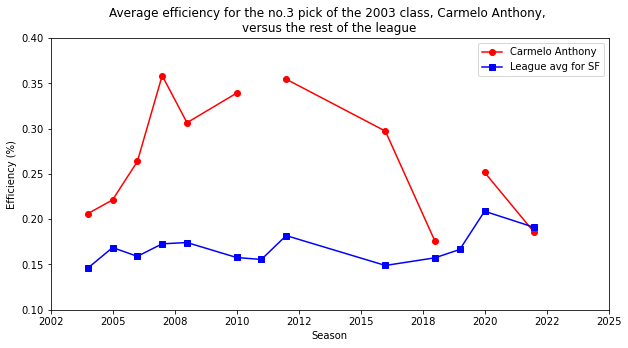

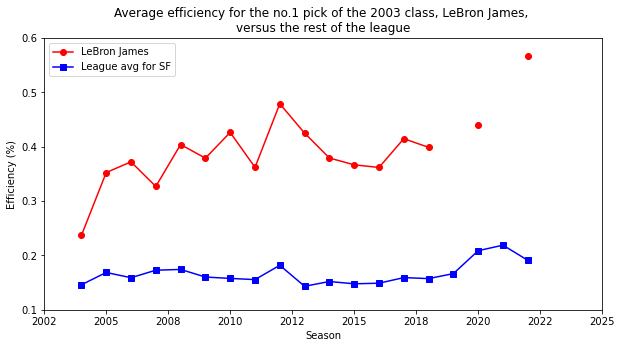

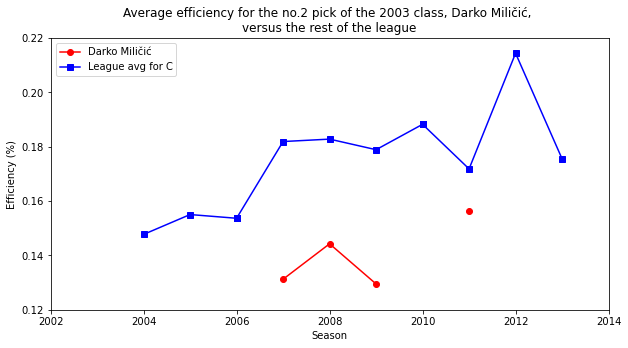

In [39]:
league_avg = df.groupby(["Pos","Season"])["Efficiency"].mean().reset_index(name="Avg League Eff")

for player in top_3_2003:
    # Find the player's most commonly played position
    all_positions = dict(df.loc[df["Player"] == player, "Pos"].value_counts())
    position = max(all_positions, key=all_positions.get)
    
    # Create a table with the player's efficiency and avg. league efficiency for each season
    player_data = df.loc[df["Player"] == str(player),["Player","Season","Efficiency"]]
    avg_for_pos = league_avg.loc[league_avg["Pos"] == position]
    plot_data = pd.merge(player_data, avg_for_pos, how="left", on=["Season"])
    
    # Plot both lines
    plt.figure(figsize=(10,5))
    plt.plot(plot_data["Season"], plot_data["Efficiency"], label=str(player), color="red", marker="o")
    plt.plot(plot_data["Season"], plot_data["Avg League Eff"], label=f"League avg for {position}", color="blue", marker="s")
    
    
    # Add labels and title
    plt.xlabel("Season")
    plt.ylabel("Efficiency (%)")
    plt.gca().xaxis.set_major_formatter(formatter)
    
    draft_position = int(df.loc[df["Player"] == player , "draft_pick"].min())
    plt.title(f"Average efficiency for the no.{draft_position} pick of the 2003 class, {player}, \nversus the rest of the league")
    plt.legend()
    plt.show()